#  Based on Anna-Marrie's code used for own learning

#  Ship Image Recognition

In this notebook we are going to build a predictive classification model for recognizing ships from Satellite imagery.

The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.


**Introduction to Satellite Image Processing**
<br>
Satellite imagery provides unique insights into various markets, including agriculture, defense and intelligence, energy, and finance. New commercial imagery providers, such as Planet, are using constellations of small satellites to capture images of the entire Earth every day. This flood of new imagery is outgrowing the ability for organizations to manually look at each image that gets captured, and there is a need for machine learning and computer vision algorithms to help automate the analysis process.

#  Set Up

In [49]:
# Data Manipulation & analysis
import json
import pandas as pd
import numpy as np
from scipy import stats

# Visualizations
from matplotlib import pyplot as plt

# Data Preparation
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb # In terminal: pip install xgboost
from xgboost import XGBClassifier

# Evaluation
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

# GIS-Specific
from skimage import color
from skimage.feature import hog

# Other Set Up
from datetime import datetime
import os
import warnings
from pprint import pprint

# Set Random Seed
np.random.seed(42)

#  Data Understanding

The dataset consists of image chips extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. It includes 4000 80x80 RGB images labeled with either a "ship" or "no-ship" classification. Image chips were derived from PlanetScope full-frame visual scene products, which are orthorectified to a 3 meter pixel size.

Provided is a zipped directory shipsnet.zip that contains the entire dataset as .png image chips. Each individual image filename follows a specific format: {label} __ {scene id} __ {longitude} _ {latitude}.png

- label: Valued 1 or 0, representing the "ship" class and "no-ship" class, respectively.
- scene id: The unique identifier of the PlanetScope visual scene the image chip was extracted from. The scene id can be used with the Planet API to discover and download the entire scene.
- longitude_latitude: The longitude and latitude coordinates of the image center point, with values separated by a single underscore.

The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order, so that the first 80 entries of the array are the red channel values of the first row of the image.

The list values at index i in labels, scene_ids, and locations each correspond to the i-th image in the data list.

In [7]:
# Open the directory path in which the json file is stored
path = '../ships/shipsnet.json'

with open(path) as file:
    dataset = json.load(file)

#Display the main keys where data is stored
dataset.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [9]:
# Load json data as DataFrame
ships_df= pd.DataFrame(dataset)

In [17]:
ships_df.tail(1000)

,data,labels,locations,scene_ids
3000,"[139, 136, 134, 134, 134, 132, 135, 134, 125, ...",0,"[-122.24194756594893, 37.719697389134595]",20170602_010249_0c44
3001,"[116, 111, 113, 108, 98, 95, 99, 105, 106, 104...",0,"[-122.40001517542525, 37.6960287584367]",20170505_181258_0e2f
3002,"[107, 109, 116, 121, 120, 113, 111, 122, 144, ...",0,"[-122.16455479704005, 37.80632124815938]",20170730_191231_0f21
3003,"[108, 110, 112, 114, 106, 114, 117, 113, 119, ...",0,"[-122.37168169222907, 37.74690485775517]",20170129_181027_0e1f
3004,"[101, 107, 110, 106, 108, 105, 107, 113, 112, ...",0,"[-122.43919822115103, 37.865325923311175]",20170706_181011_1006
...,...,...,...,...
3995,"[126, 122, 124, 138, 165, 186, 195, 199, 203, ...",0,"[-122.08693255500694, 37.77781408256089]",20170815_180821_102d
3996,"[130, 134, 139, 128, 117, 126, 141, 147, 142, ...",0,"[-122.10549691828378, 37.76946626247702]",20170730_191230_0f21
3997,"[171, 135, 118, 140, 145, 144, 154, 165, 139, ...",0,"[-122.48298739296371, 37.684929808845375]",20161116_180804_0e14
3998,"[85, 90, 94, 95, 94, 92, 93, 96, 93, 94, 94, 9...",0,"[-122.29028216570079, 37.71632091139081]",20170211_181116_0e16


In [11]:
# Print data dimensions
print("Rows :", len(ships_df['data'])) 
print("Columns :", len(ships_df['data'][0]))

Rows : 4000
Columns : 19200


In [12]:
# Seperate data and save as array
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [14]:
x[:5, :5]

array([[ 82,  89,  91,  87,  89],
       [ 76,  75,  67,  62,  68],
       [125, 127, 129, 130, 126],
       [102,  99, 113, 106,  96],
       [ 78,  76,  74,  78,  79]], dtype=uint8)

In [15]:
y[:5]

array([1, 1, 1, 1, 1], dtype=uint8)

In [21]:
# Print Descriptions
def describeData(x,y):
    print('Total number of images: {}'.format(len(x)))
    print('Number of NoShip Images: {}'.format(np.sum(y==0)))
    print('Number of Ship Images: {}'.format(np.sum(y==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(y)))
    print('Image shape (Width, Height, Channels): {}'.format(x[0].shape))
describeData(x,y)

Total number of images: 4000
Number of NoShip Images: 3000
Number of Ship Images: 1000
Percentage of positive images: 25.00%
Image shape (Width, Height, Channels): (19200,)


### Prepare data for visualising samples

In [22]:
## converts a class vector (integers) to binary class matrix
def to_categorical(y, num_classes=None, dtype='float32'):
  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical


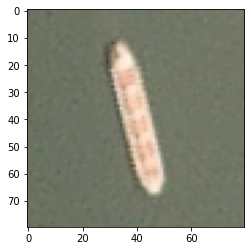

In [29]:
# RGB spectrums
n_spectrums = 3 

# Chose 80x80 cm dimension for each image
img_length = 80

# Data willl be split to 3 spectrums in which each of the 3 spectrums will contain the 2D dimensions of each image
# -1 for numpy to calculate the number of dimensions needed to split the data to
xReshaped = x.reshape([-1, n_spectrums, img_length, img_length]).transpose([0,2,3,1])
yReshaped = to_categorical(y, num_classes=2)

# View one image at random
plt.imshow(xReshaped[321])

In [30]:
# Define Plot histogram of RGB Pixel Intensities
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('Ship' if y[1] else 'Not A Ship')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

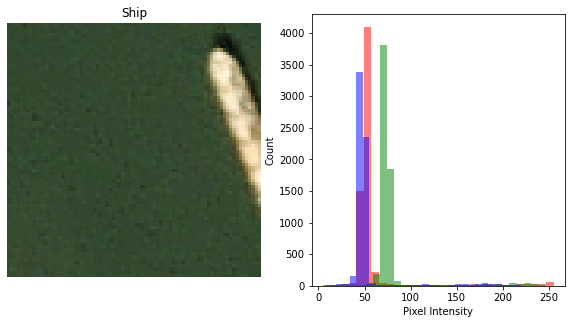

In [42]:
# Plot Histogram for a sample 
plotHistogram(xReshaped[2347])

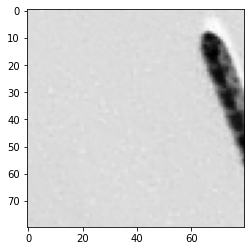

In [44]:
# Show in Greyscale
plt.imshow(color.rgb2gray(xReshaped[2347]))
plt.set_cmap('Greys')

#  Data Preparation

**Normalisation**

In [45]:
# Scale by 255.0 to convert RGB pixel values to floats.
x = x / 255.0

In [46]:
x[:5]

array([[0.32156863, 0.34901961, 0.35686275, ..., 0.3372549 , 0.34509804,
        0.34901961],
       [0.29803922, 0.29411765, 0.2627451 , ..., 0.21176471, 0.22352941,
        0.22745098],
       [0.49019608, 0.49803922, 0.50588235, ..., 0.43529412, 0.42745098,
        0.45098039],
       [0.4       , 0.38823529, 0.44313725, ..., 0.36862745, 0.37254902,
        0.30196078],
       [0.30588235, 0.29803922, 0.29019608, ..., 0.33333333, 0.3372549 ,
        0.3254902 ]])

**Splitting**

In [47]:
# Split data 80:20
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 ,random_state = 123)

**Image Enhancement**

In [19]:
# Image enhancement is the process of adjusting digital images so that the results are more suitable
# for display or further image analysis.

############################
## TRY DIFFERENT METHODS ###
############################

**Feature Extraction**

In [21]:
# Feature descriptors are representations of an image or an image patch that simplifies the image
# by extracting useful information and throwing away extraneous information.

#############################
## TRY FEATURE DESCRIPTORS ##
#############################

# Modeling

**Model Selection**

In [50]:
# Model Selection based on popular Machine Learning models & 3-fold cross-validation
def modelSelection(a,b):   
    # Define Scoring Metrics
    scoring = ['roc_auc', 'accuracy','precision', 'recall']
    # Define Models
    models = []
    models.append(('LR', LogisticRegression()))
#    models.append(('RF', RandomForestClassifier()))
#     models.append(('KNN', KNeighborsClassifier()))
#     models.append(('GNB', GaussianNB()))
    models.append(('DTC', DecisionTreeClassifier()))
#    models.append(('XGB', XGBClassifier())) 
    names = []
    results = []
    # Cross Validate Models
    for name, model in models:
        scores = cross_validate(model, a, b, cv=3, scoring=scoring)
        resultsMessage = "%s: AUC %f Accuracy %f Precision %f Recall %f"  % ((name,
                       scores['test_roc_auc'].mean(),
                       scores['test_accuracy'].mean(),
                       scores['test_precision'].mean(),
                       scores['test_recall'].mean()))
        print(resultsMessage)
    return

In [51]:
# Compare metrics
warnings.simplefilter(action='ignore', category=FutureWarning) # Hide warnings

modelSelection(x_train,y_train)

C:\Users\Abdulaziz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Abdulaziz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/s

LR: AUC 0.944573 Accuracy 0.901877 Precision 0.783327 Recall 0.843547
DTC: AUC 0.870703 Accuracy 0.896564 Precision 0.781088 Recall 0.818648


# Evaluation

In [52]:
# Fit the final model
finalmodel = LogisticRegression().fit(x_train, y_train)

C:\Users\Abdulaziz\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
# Make sure to apply any data preparation on test data as well (x_test,y_test)

In [53]:
# Use final model to predict on test set
y_pred = finalmodel.predict(x_test)

In [54]:
# Print Evaluation metrics
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))
print('\n')
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred))

Accuracy: 0.93125


              precision    recall  f1-score   support

           0       0.95      0.96      0.95       605
           1       0.86      0.86      0.86       195

    accuracy                           0.93       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.93      0.93      0.93       800



Confusion Matrix
[[578  27]
 [ 28 167]]
